In [48]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from tqdm import tqdm,trange

# Set parameters

In [49]:
num_train_examples = 100000
max_train_length = 10

num_test_examples = 10000
min_test_length=5
max_test_length=100
step_test_length=5

# Generate train data

In [70]:
X = np.ones((num_train_examples,max_train_length))
prod_X = np.ones((num_train_examples))
for i in tqdm(range(num_train_examples), desc='Generating train examples: '):
    n = np.random.randint(1,max_train_length)
    for j in range(1,n+1):
        X[i,-j] = np.random.randint(1,3)
    prod_X[i] = np.product(X[i])

Generating train examples: 100%|███████████████████████| 100000/100000 [00:02<00:00, 37286.08it/s]


In [71]:
print(X[0:10])
print(prod_X[0:10])

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 2. 2.]
 [1. 1. 1. 1. 1. 2. 1. 2. 1. 1.]
 [1. 1. 1. 1. 1. 1. 2. 1. 2. 2.]
 [1. 1. 1. 1. 2. 1. 2. 2. 2. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 1. 1. 1. 2. 1.]
 [1. 1. 1. 1. 1. 2. 1. 2. 2. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]]
[ 2.  2.  4.  4.  8. 16.  1.  4.  8.  2.]


# Generate test data

In [72]:
def gen_test_data(num_examples, length):
    Y = np.ones((num_examples, length))
    prod_Y = np.ones((num_examples))
    for i in range(num_examples):
        for j in range(1,length+1):
            Y[i,-j] = np.random.randint(1,3)  # np.random.uniform()+0.5
        prod_Y[i] = np.product(Y[i])
    return Y, prod_Y

# DeepSet Model

In [78]:
def get_deepset_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 1000, mask_zero=True)(input_txt)
    x = Dense(300, activation='tanh')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# LSTM Model

In [79]:
def get_lstm_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 1000, mask_zero=True)(input_txt)
    x = LSTM(50)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# GRU Model

In [80]:
def get_gru_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 1000, mask_zero=True)(input_txt)
    x = GRU(80)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Train Deepset model

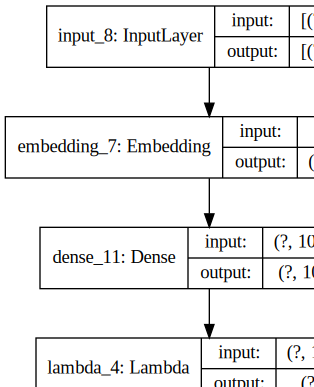

In [81]:
# model
model = get_deepset_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [82]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=True)

model.fit(X, prod_X, epochs=10, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights.hdf5')

# save weights
deep_we = []
for i in [1,2,4]:
    w = model.get_layer(index=i).get_weights()
    deep_we.append(w)

Epoch 1/10
772/772 [==============================] - 16s 21ms/step - loss: 6.2035 - val_loss: 6.1579
Epoch 2/10
772/772 [==============================] - 18s 23ms/step - loss: 5.8121 - val_loss: 6.1787
Epoch 3/10
 77/772 [=>............................] - ETA: 16s - loss: 6.1778

KeyboardInterrupt: 

# Train LSTM model

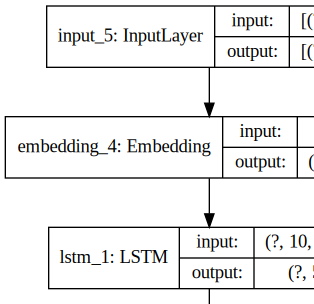

In [59]:
# model
model = get_lstm_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [60]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights1.hdf5', verbose=0, save_best_only=True)

model.fit(X, prod_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights1.hdf5')

# save weights
lstm_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    lstm_we.append(w)

Epoch 1/50
199/772 [======>.......................] - ETA: 26s - loss: 709.7595

KeyboardInterrupt: 

# Train GRU model

In [ ]:
# model
model = get_gru_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights2.hdf5', verbose=0, save_best_only=True)

model.fit(X, prod_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights2.hdf5')

# save weights
gru_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    gru_we.append(w)

# Evaluate models

In [ ]:
metrics = {'deepsets': {'acc':[], 'mae':[], 'mse':[]}, 'lstm': {'acc':[], 'mae':[], 'mse':[]}, 'gru': {'acc':[], 'mae':[], 'mse':[]}}

lengths = range(min_test_length, max_test_length, step_test_length)
for l in lengths:
    print('Evaluating at length: ', l)
    K.clear_session()
    
    # generate test data
    Y, prod_Y = gen_test_data(num_test_examples, l)

    # model
    model = get_deepset_model(l)

    # load weights
    for i, idx in enumerate([1,2,4]):
        model.get_layer(index=idx).set_weights(deep_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['deepsets']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==np.round(prod_Y))/len(prod_Y))
    metrics['deepsets']['mae'].append(np.sum(np.abs(np.squeeze(preds)-prod_Y))/len(prod_Y))
    metrics['deepsets']['mse'].append(np.dot(np.squeeze(preds)-prod_Y, np.squeeze(preds)-prod_Y)/len(prod_Y))
    
    # model
    model = get_lstm_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(lstm_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['lstm']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==np.round(prod_Y))/len(prod_Y))
    metrics['lstm']['mae'].append(np.sum(np.abs(np.squeeze(preds)-prod_Y))/len(prod_Y))
    metrics['lstm']['mse'].append(np.dot(np.squeeze(preds)-prod_Y, np.squeeze(preds)-prod_Y)/len(prod_Y))
    
    # model
    model = get_gru_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(gru_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['gru']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==np.round(prod_Y))/len(prod_Y))
    metrics['gru']['mae'].append(np.sum(np.abs(np.squeeze(preds)-prod_Y))/len(prod_Y))
    metrics['gru']['mse'].append(np.dot(np.squeeze(preds)-prod_Y, np.squeeze(preds)-prod_Y)/len(prod_Y))

Compare the performance

In [ ]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, metrics['deepsets']['acc'], 'o-')
plt.plot(lengths, metrics['lstm']['acc'], 'o-')
plt.plot(lengths, metrics['gru']['acc'], 'o-')
plt.xlabel('Number of digits to add')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.ylim( 0, 1.1 )
plt.xlim( 5, 95 )
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mae'])/1e2, 'x-')
plt.xlabel('Number of digits to multiply')
plt.ylabel('Mean absolute error/1e2')
plt.title('MAE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mse'])/1e5, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mse'])/1e5, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mse'])/1e5, 'x-')
plt.xlabel('Number of digits to multiply')
plt.ylabel('Mean square error/1e5')
plt.title('MSE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()